### Evaluation

Se realiza una evaluación de los modelos analizados a través de la curva ROC

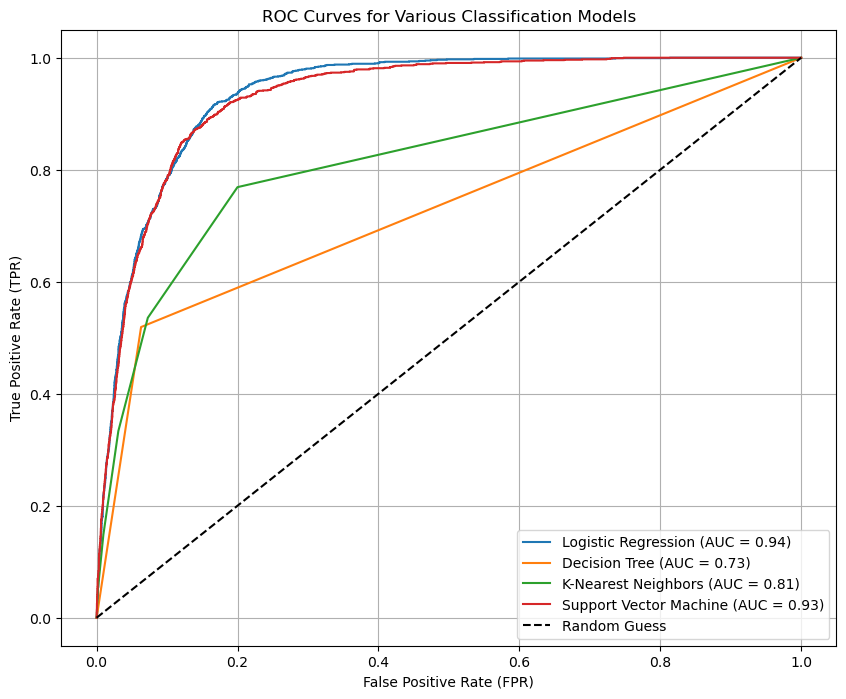

In [47]:
# Importar las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Cargar y preprocesar el conjunto de datos bank-additional-full.csv
data = pd.read_csv('data/bank-additional-full.csv', sep=';')
label_encoder = LabelEncoder()
data['y'] = label_encoder.fit_transform(data['y'])  # Convertir la columna objetivo a binario

# Convertir variables categóricas a dummy y luego cambiar booleans a binarios
data = pd.get_dummies(data, drop_first=True)
data = data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

# Separar las características y el objetivo
X = data.drop('y', axis=1)
y = data['y']

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Definir modelos de clasificación
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True)  # Para SVM, es necesario usar `probability=True` para obtener probabilidades
}

# Graficar la curva ROC para cada modelo
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Obtener las probabilidades para la clase positiva
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calcular la curva ROC y el AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Configuración de la gráfica
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Various Classification Models')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
### Análisis de Sensibilidad



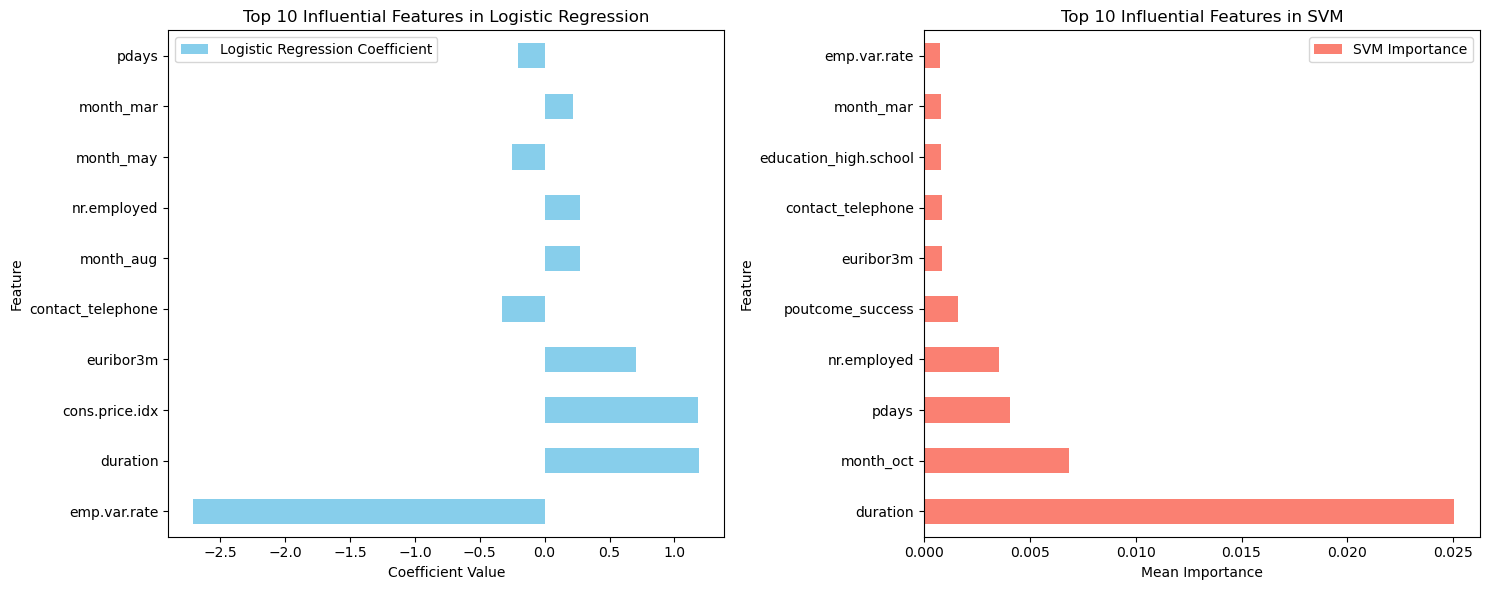

In [51]:
# Importar las librerías necesarias
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Cargar y preprocesar el conjunto de datos
data = pd.read_csv('data/bank-additional-full.csv', sep=';')
label_encoder = LabelEncoder()
data['y'] = label_encoder.fit_transform(data['y'])  # Convertir la variable objetivo a binaria

# Convertir variables categóricas en variables dummy y transformar booleanos a binarios
data = pd.get_dummies(data, drop_first=True)
data = data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

# Separar las características y la variable objetivo
X = data.drop('y', axis=1)
y = data['y']

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Entrenar modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Entrenar modelo SVM con probabilidad
svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Obtener la importancia de las características en la Regresión Logística
log_reg_coef = pd.DataFrame({
    'Feature': X.columns,
    'Logistic Regression Coefficient': log_reg.coef_[0]
})
log_reg_coef['Abs_Coefficient'] = log_reg_coef['Logistic Regression Coefficient'].abs()
log_reg_coef = log_reg_coef.sort_values(by='Abs_Coefficient', ascending=False)

# Análisis de sensibilidad usando Permutation Importance para SVM
perm_importance = permutation_importance(svm, X_test, y_test, n_repeats=30, random_state=42)
svm_importance = pd.DataFrame({
    'Feature': X.columns,
    'SVM Importance': perm_importance.importances_mean
})
svm_importance = svm_importance.sort_values(by='SVM Importance', ascending=False)

# Merge de ambos resultados
sensitivity_analysis = pd.merge(log_reg_coef[['Feature', 'Logistic Regression Coefficient']], 
                                svm_importance[['Feature', 'SVM Importance']], 
                                on='Feature')

# Visualización de resultados de sensibilidad
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Coeficientes de Regresión Logística
sensitivity_analysis.sort_values('Logistic Regression Coefficient', key=abs, ascending=False).head(10).plot(
    x='Feature', y='Logistic Regression Coefficient', kind='barh', ax=ax[0], color='skyblue')
ax[0].set_title('Top 10 Influential Features in Logistic Regression')
ax[0].set_xlabel('Coefficient Value')

# Importancia de características en SVM mediante Permutation Importance
sensitivity_analysis.sort_values('SVM Importance', ascending=False).head(10).plot(
    x='Feature', y='SVM Importance', kind='barh', ax=ax[1], color='salmon')
ax[1].set_title('Top 10 Influential Features in SVM')
ax[1].set_xlabel('Mean Importance')

plt.tight_layout()
plt.show()
